In [1]:
# importing some libraries
import pyspark
from pyspark.sql import SQLContext, SparkSession
import os
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel# reading the data
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))

22/04/10 19:37:26 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/10 19:37:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/10 19:37:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/10 19:37:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
classics = data.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [3]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [4]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [5]:
result_cv

DataFrame[list_of_words: array<string>, index: bigint, raw_features: vector]

In [6]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/10 19:37:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/10 19:37:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [7]:
lda_model.vocabSize()

476

In [8]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[34, 52, 60, 53, ...|[0.04222865639711...|
|    1|[8, 13, 11, 28, 3...|[0.08155521196563...|
|    2|[1, 16, 23, 29, 4...|[0.12926925880183...|
|    3|[4, 14, 36, 46, 3...|[0.08080935973085...|
|    4|[2, 3, 32, 39, 72...|[0.12138838394343...|
|    5|[19, 21, 20, 40, ...|[0.05628682837866...|
|    6|[0, 17, 15, 30, 7...|[0.28140524036190...|
|    7|[5, 12, 24, 22, 4...|[0.10060171888994...|
|    8|[10, 33, 47, 59, ...|[0.07035355612906...|
|    9|[6, 9, 7, 25, 18,...|[0.06845528137139...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [9]:
lda_model.topicsMatrix()

DenseMatrix(476, 10, [0.5454, 0.1601, 0.1533, 0.1501, 0.9508, 0.1593, 0.1627, 0.1598, ..., 0.1445, 72.2856, 0.1561, 0.2079, 0.1512, 0.1412, 0.1572, 0.1672], 0)

In [10]:
vocabulary = cvmodel.vocabulary

In [11]:
topics_model = lda_model.describeTopics()

In [12]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [13]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[34, 52, 60, 53, ...|[0.04222865639711...|[love, back, hand...|
|    1|[8, 13, 11, 28, 3...|[0.08155521196563...|[think, looking, ...|
|    2|[1, 16, 23, 29, 4...|[0.12926925880183...|[would, might, we...|
|    3|[4, 14, 36, 46, 3...|[0.08080935973085...|[little, come, la...|
|    4|[2, 3, 32, 39, 72...|[0.12138838394343...|[could, like, cri...|
|    5|[19, 21, 20, 40, ...|[0.05628682837866...|[made, even, make...|
|    6|[0, 17, 15, 30, 7...|[0.28140524036190...|[said, miss, thou...|
|    7|[5, 12, 24, 22, 4...|[0.10060171888994...|[never, good, tel...|
|    8|[10, 33, 47, 59, ...|[0.07035355612906...|[though, anne, lo...|
|    9|[6, 9, 7, 25, 18,...|[0.06845528137139...|[must, shall, kno...|
+-----+--------------------+--------------------+--------------------+



In [14]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[34, 52, 60, 53, ...|[0.04222865639711...|love back hand wa...|
|    1|[8, 13, 11, 28, 3...|[0.08155521196563...|think looking muc...|
|    2|[1, 16, 23, 29, 4...|[0.12926925880183...|would might went ...|
|    3|[4, 14, 36, 46, 3...|[0.08080935973085...|little come lauri...|
|    4|[2, 3, 32, 39, 72...|[0.12138838394343...|could like cried ...|
|    5|[19, 21, 20, 40, ...|[0.05628682837866...|made even make ca...|
|    6|[0, 17, 15, 30, 7...|[0.28140524036190...|said miss thought...|
|    7|[5, 12, 24, 22, 4...|[0.10060171888994...|never good tell q...|
|    8|[10, 33, 47, 59, ...|[0.07035355612906...|though anne looke...|
|    9|[6, 9, 7, 25, 18,...|[0.06845528137139...|must shall know a...|
+-----+--------------------+--------------------+--------------------+



In [23]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)

In [26]:
counts.show()

+--------+-----+
|    word|count|
+--------+-----+
|   often|    1|
|    hand|    1|
|    back|    1|
|    face|    1|
|    love|    1|
|  mother|    1|
|   whose|    1|
|    want|    1|
|dorothea|    1|
|    tone|    1|
|    eyes|    1|
| looking|    1|
|    much|    1|
|    away|    1|
|   began|    1|
|    help|    1|
| lydgate|    1|
|   think|    1|
|    home|    1|
|   since|    1|
+--------+-----+
only showing top 20 rows



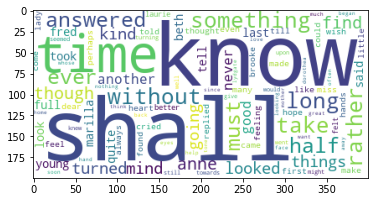

In [27]:
import pyspark.sql.functions as F
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
